#**Cost Prediction For Logistic Company**

**Problem Statement:** To optimize the delivery network of a logistics company, the dataset is provided with delivery information and associated trip costs.

**Task:** To build a model to predict the cost of deliveries.

# **Importing Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
import random
from pandas.plotting import scatter_matrix
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
import os
import tarfile
from six.moves import urllib

# Importing tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax, Dropout
from tensorflow.keras import optimizers

In [ ]:
# Checking the tensorflow libraries
print(tf.__version__)

2.12.0


#**Data Extraction**

In [ ]:
#Read train.csv file into pandas dataframe
dataset_train = pd.read_csv("/content/sample_data/train.csv")

#dataset_train = pd.read_csv(file_url_train) #reading train.csv to pandas data frame

In [ ]:
#Sum of null values
dataset_train.isnull().sum()

trip                       0
date                       0
dayPart                    0
exWeatherTag           34117
originLocation             0
destinationLocation        0
distance                   0
type                   35251
weight                     0
packageType            36499
carrier                    0
cost                       0
dtype: int64

In [ ]:
#Overiew of Data
dataset_train.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777


In [ ]:
#List of columns present
list(dataset_train.columns)

['trip',
 'date',
 'dayPart',
 'exWeatherTag',
 'originLocation',
 'destinationLocation',
 'distance',
 'type',
 'weight',
 'packageType',
 'carrier',
 'cost']

In [ ]:
#Number of Columns present
len(dataset_train.columns)

12

# **Data Visualizations**

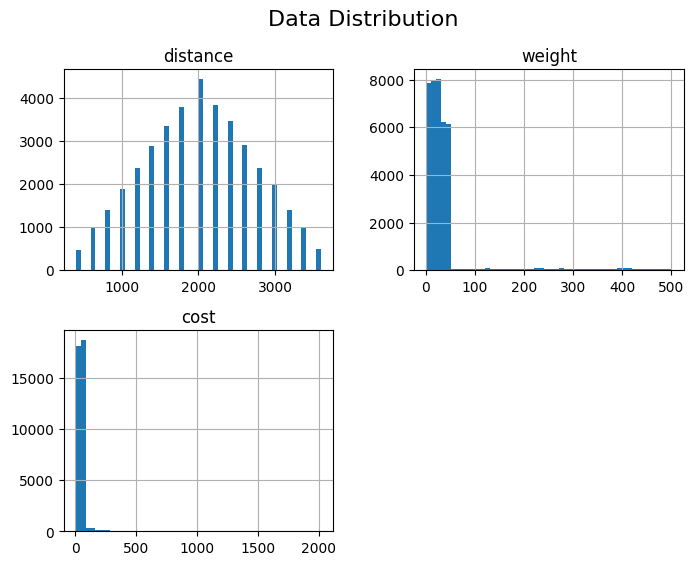

In [ ]:
#Histogram plot for the train data
dataset_train.hist(bins=50, figsize=(8, 6))
plt.suptitle("Data Distribution", fontsize=16)
plt.show()

Distance: The histogram for the "distance" feature appears to have a relatively normal distribution. The data is spread out around the central value, and the majority of the distances fall within a certain range. This indicates that the distances covered by the deliveries are evenly distributed, which is a positive characteristic for a logistic company's operations.

Cost: The histogram for the "cost" feature is right-skewed. This means that the majority of the delivery costs are clustered on the lower end, but there are a few deliveries with significantly higher costs that are pulling the distribution to the right. Right-skewed distributions are often associated with a long tail on the right side, indicating that some deliveries might be more expensive than others.

Weight: Similarly, the histogram for the "weight" feature is also right-skewed. This suggests that most deliveries have relatively low weights, while a smaller number of deliveries have higher weights. This could potentially indicate that there are a few heavy deliveries that contribute to the right skewness.

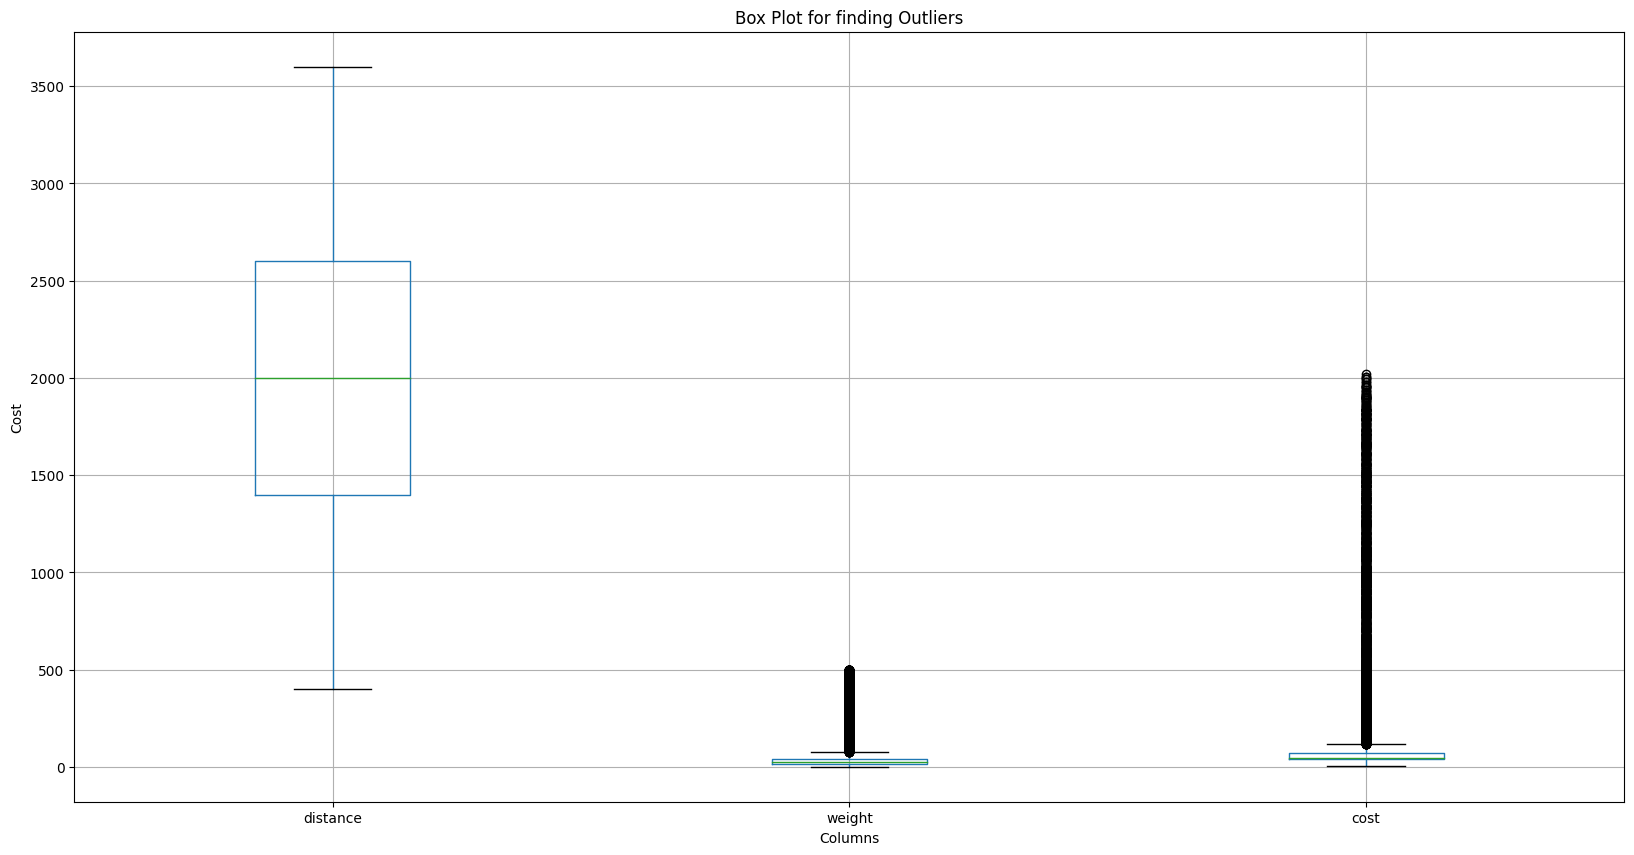

In [ ]:
# Figuring out outliers. Adding boxplot
dataset_train.boxplot(figsize=(20,10))
plt.xlabel("Columns")
plt.ylabel("Cost")
plt.title('Box Plot for finding Outliers')
plt.grid(True)
plt.show()

Distance: The "distance" feature shows a box with a median line inside. Since there are no outliers for the "distance" feature, the box is not extended by whiskers, and all data points within the range are contained within the box. This suggests that the distances covered by most deliveries are consistent and do not deviate significantly from the median distance.

Cost: The "cost" feature includes a box with a median line inside. The whiskers extend to data points that are considered potential outliers. Outliers in the "cost" feature indicate that some deliveries have unusually high costs compared to the majority of deliveries. These high-cost outliers might be influenced by specific circumstances, delivery requirements, or other factors.

Weight: Similarly, the "weight" feature exhibits a box plot with whiskers extending to potential outliers. Outliers in the "weight" feature suggest that there are deliveries with significantly higher weights than the majority of deliveries. These heavy-weight outliers may have specific implications for logistics operations.

**Plotting scatter_matrix**

Scatter matrix is a grid of scatter plots where each plot represents the relationship between two variables in a dataset. It helps visualize correlations and patterns between variables, aiding in exploratory data analysis and providing insights for modeling

array([[<Axes: xlabel='distance', ylabel='distance'>,
        <Axes: xlabel='weight', ylabel='distance'>,
        <Axes: xlabel='cost', ylabel='distance'>],
       [<Axes: xlabel='distance', ylabel='weight'>,
        <Axes: xlabel='weight', ylabel='weight'>,
        <Axes: xlabel='cost', ylabel='weight'>],
       [<Axes: xlabel='distance', ylabel='cost'>,
        <Axes: xlabel='weight', ylabel='cost'>,
        <Axes: xlabel='cost', ylabel='cost'>]], dtype=object)

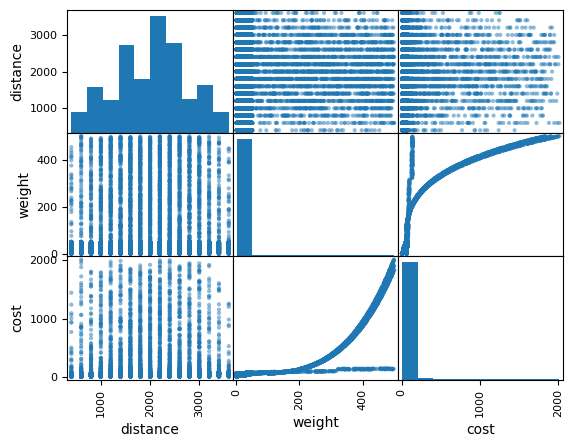

In [ ]:
scatter_matrix(dataset_train)

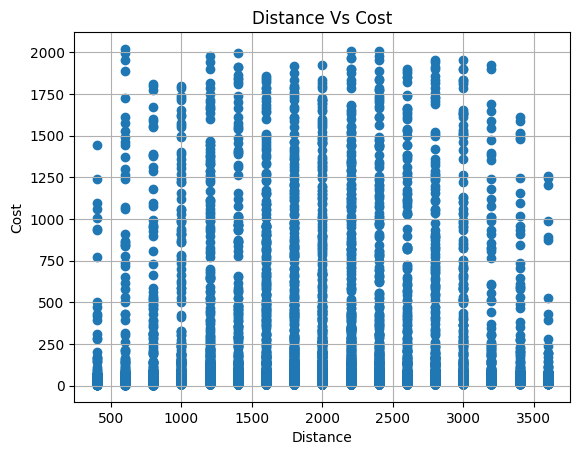

In [ ]:
#Plotting the Scatter plot for Distance and Cost
plt.scatter(dataset_train["distance"], dataset_train["cost"])
plt.xlabel("Distance")
plt.ylabel("Cost")
plt.title('Distance Vs Cost')
plt.figsize=(20,20)
plt.grid(True)
plt.show()

**Plotting line plot**

 Line plot is a simple and effective way to visualize the relationship between two variables by connecting data points with straight lines. It helps in identifying trends and patterns in the data

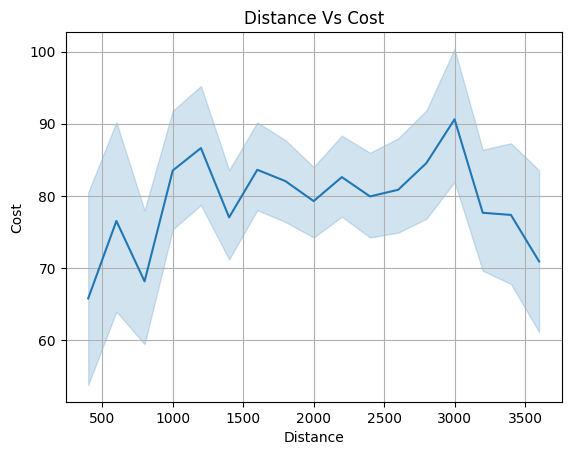

In [ ]:
sns.lineplot(x="distance", y="cost", data=dataset_train)
plt.xlabel("Distance")
plt.ylabel("Cost")
plt.title('Distance Vs Cost')
plt.grid(True)
plt.show()

#**Feature Engineering**

In [ ]:
#Function to modify date
def formatDate(df):
  df['date'] = pd.to_datetime(df['date'])  # Convert 'dates' to datetime format
  df['day_of_week'] = df['date'].dt.dayofweek
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  return df

In [ ]:
formatDate(dataset_train)

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost,day_of_week,month,year
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152,2,9,2017
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649,5,10,2017
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939,5,7,2017
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087,6,10,2017
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777,2,12,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994,t11845608590,2019-10-17,night,NaN,S3,D3,1200,NaN,3,NaN,B,14.987239,3,10,2019
38995,t53557166488,2019-01-23,night,NaN,S4,D6,2000,NaN,6,NaN,B,33.214738,2,1,2019
38996,t337474787136,2018-10-03,night,NaN,S8,D7,3000,NaN,24,NaN,B,45.172159,2,10,2018
38997,t76488353326,2018-02-26,night,NaN,S8,D5,2600,NaN,31,NaN,B,47.541427,0,2,2018


In [ ]:
#Function to find mode for categorical values and replace null values with the mode
def findModeAndApplyModeToNullValues(dataset):
  categoricalColumnsWithNullValues = ['exWeatherTag', 'type', 'packageType']
  for column in categoricalColumnsWithNullValues:
    if column == 'exWeatherTag':
      # Assuming the null values represents the normal weather conditions, it is being filled with the value 'normal'
      # Filling the null values with mode or any other imputation method could effect the model and prediction.
      mode_of_the_column = 'normal'
    else:
      mode_of_the_column = dataset[column].mode()
    dataset[column] = dataset[column].replace([np.NaN], mode_of_the_column)
  return dataset


def calculateMetrics(y_val, y_pred):
  # Calculate Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_val, y_pred)
  print("Mean Absolute Error (MAE):", mae)

  # Calculate Mean Squared Error (MSE)
  mse = mean_squared_error(y_val, y_pred)
  print("Mean Squared Error (MSE):", mse)

  # Calculate Root Mean Squared Error (RMSE)
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  print("Root Mean Squared Error (RMSE):", rmse)

  # Calculate R-squared (Coefficient of Determination)
  r2 = r2_score(y_val, y_pred)
  print("R-squared (Coefficient of Determination):", r2)

def adjusted_r_squared(y_val, y_pred, n, p):
  r2 = r2_score(y_val, y_pred)
  adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
  print("Adjusted R-squared:", adjusted_r2)
  return adjusted_r2

In [ ]:
dataset_train = findModeAndApplyModeToNullValues(dataset_train)

In [ ]:
#Ensuring there are no null values for the model training.
dataset_train.isnull().sum()

trip                   0
date                   0
dayPart                0
exWeatherTag           0
originLocation         0
destinationLocation    0
distance               0
type                   0
weight                 0
packageType            0
carrier                0
cost                   0
day_of_week            0
month                  0
year                   0
dtype: int64

In [ ]:
#Choosing a nre dataset_train which is described as dataset_train Modified as dataset_train_modified to drop the redundant values of Date, Trip ID
#Cost has been dropped in order to evaluate the training model in this train itself
dataset_train_modified = dataset_train
dataset_train_modified = dataset_train_modified.drop(['trip', 'date'],axis=1)

dataset_train_modified.describe()

,distance,weight,cost,day_of_week,month,year
count,38999.000000,38999.000000,38999.000000,38999.000000,38999.000000,38999.000000
mean,2004.061643,42.293033,80.972210,2.993590,6.502910,2017.995590
std,728.996843,75.473752,180.715055,2.010195,3.444621,0.815877
min,400.000000,1.000000,5.000000,0.000000,1.000000,2017.000000
25%,1400.000000,13.000000,38.768742,1.000000,4.000000,2017.000000
50%,2000.000000,25.000000,46.468476,3.000000,6.000000,2018.000000
75%,2600.000000,39.000000,70.239797,5.000000,9.000000,2019.000000
max,3600.000000,500.000000,2019.734797,6.000000,12.000000,2019.000000


In [ ]:
dataset_train_modified =pd.get_dummies(dataset_train_modified, columns=['dayPart','carrier','exWeatherTag','originLocation','destinationLocation','type','packageType'])


In [ ]:
dataset_train_modified

,distance,weight,cost,day_of_week,month,year,dayPart_day,dayPart_night,carrier_A,carrier_B,...,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9,type_expedited,packageType_TT
0,2200,50,68.413152,2,9,2017,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
1,1800,12,36.450649,5,10,2017,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
2,2800,1,9.057939,5,7,2017,0,1,0,1,...,0,0,0,1,0,0,0,0,1,1
3,3200,50,57.320087,6,10,2017,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,2000,43,77.263777,2,12,2019,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994,1200,3,14.987239,3,10,2019,0,1,0,1,...,0,1,0,0,0,0,0,0,1,1
38995,2000,6,33.214738,2,1,2019,0,1,0,1,...,0,0,0,0,1,0,0,0,1,1
38996,3000,24,45.172159,2,10,2018,0,1,0,1,...,0,0,0,0,0,1,0,0,1,1
38997,2600,31,47.541427,0,2,2018,0,1,0,1,...,0,0,0,1,0,0,0,0,1,1


Keer code

# 3. Feature Scaling and test train split

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder ,StandardScaler
from sklearn.model_selection import train_test_split

# Splitting the Data into Training and Testing Sets
train_set, test_set = train_test_split(dataset_train_modified, test_size=0.3, random_state=42)

# Defining target column as cost
target = 'cost'
features = list(train_set.columns)
features = [f for f in features if f!=target]

#features = [f for f in features if f!=target]
X_train = train_set[features]
y_train = train_set[[target]]

X_test = test_set[features]
y_test = test_set[[target]]


In [ ]:
TARGET = "cost"
columns_predictors = [col for col in train_set.columns if col not in [TARGET]]
columns_categorical = ['dayPart_day',
 'dayPart_night',
 'carrier_A',
 'carrier_B',
 'carrier_C',
 'carrier_D',
 'exWeatherTag_heat',
 'exWeatherTag_normal',
 'exWeatherTag_snow',
 'originLocation_S1',
 'originLocation_S2',
 'originLocation_S3',
 'originLocation_S4',
 'originLocation_S5',
 'originLocation_S6',
 'originLocation_S7',
 'originLocation_S8',
 'originLocation_S9',
 'destinationLocation_D1',
 'destinationLocation_D2',
 'destinationLocation_D3',
 'destinationLocation_D4',
 'destinationLocation_D5',
 'destinationLocation_D6',
 'destinationLocation_D7',
 'destinationLocation_D8',
 'destinationLocation_D9',
 'type_expedited',
 'packageType_TT']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: cost
columns_predictors: ['distance', 'weight', 'day_of_week', 'month', 'year', 'dayPart_day', 'dayPart_night', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D', 'exWeatherTag_heat', 'exWeatherTag_normal', 'exWeatherTag_snow', 'originLocation_S1', 'originLocation_S2', 'originLocation_S3', 'originLocation_S4', 'originLocation_S5', 'originLocation_S6', 'originLocation_S7', 'originLocation_S8', 'originLocation_S9', 'destinationLocation_D1', 'destinationLocation_D2', 'destinationLocation_D3', 'destinationLocation_D4', 'destinationLocation_D5', 'destinationLocation_D6', 'destinationLocation_D7', 'destinationLocation_D8', 'destinationLocation_D9', 'type_expedited', 'packageType_TT']
columns_categorical: ['dayPart_day', 'dayPart_night', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D', 'exWeatherTag_heat', 'exWeatherTag_normal', 'exWeatherTag_snow', 'originLocation_S1', 'originLocation_S2', 'originLocation_S3', 'originLocation_S4', 'originLocation_S5', 'originLocation_S6', 'origin

In [ ]:
# Splitting the Data into Training and Testing Sets
columns_categorical_list = list(columns_categorical)
columns_numerical_list = list(columns_numerical)
pipeline_numerical = Pipeline([
  ('scaler', StandardScaler()),
])

pipeline_full = ColumnTransformer([
  ("numerical", pipeline_numerical, columns_numerical_list),
])

In [ ]:
pipeline_full.fit(X_train)
X_train = pipeline_full.transform(X_train)
X_test = pipeline_full.transform(X_test)
print(f"X_train transformed.shape: {X_train.shape}")
print(f"X_test transformed.shape: {X_test.shape}")

X_train transformed.shape: (27299, 5)
X_test transformed.shape: (11700, 5)


#**Building Artifical Neural Network**

#Model 1

In [ ]:
#Keras Regressor

#Creating a new sequential neural network model using Keras.
Create_model = Sequential()

#Input Layer
Create_model.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
#This adds an input layer to the model using the Dense layer from Keras. The X_train.shape[1]
#represents the number of features in the input data. The activation function used is ReLU ('relu'). input_dim specifies the number of input dimensions.

#Hidden Layer
#adding multiple hidden layers to the model with specified number of neurons and using the ReLU activation function.
#Initial weights of the neurons will be sampled from a normal distribution.
Create_model.add(Dense(512,kernel_initializer='normal', activation='relu'))
Create_model.add(Dense(512,kernel_initializer='normal', activation='relu'))
Create_model.add(Dense(256,kernel_initializer='normal', activation='relu'))
Create_model.add(Dense(128,kernel_initializer='normal', activation='relu'))
Create_model.add(Dense(64,kernel_initializer='normal', activation='relu'))
Create_model.add(Dense(32,kernel_initializer='normal', activation='relu'))

#Output Layer
Create_model.add(Dense(1,kernel_initializer='normal', activation = 'relu'))
#This adds the output layer to the model. Since this is a
#regression problem (predicting a continuous value), a single neuron in the output layer is used with the ReLU activation function.

In [ ]:
Create_model.compile(loss = 'MeanSquaredError', optimizer='adam', metrics=['mse','mae'])
#This line compiles the model. It specifies the loss function ('MeanSquaredError') to be used during training,
# the optimizer ('adam') to update the weights based on the gradients, and additional metrics to monitor during training (['mse','mae']).
Create_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 5)                 30        
                                                                 
 dense_20 (Dense)            (None, 512)               3072      
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)               

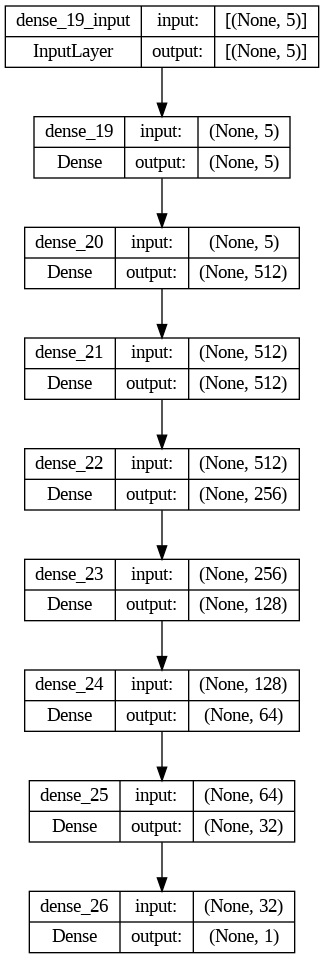

In [ ]:
tf.keras.utils.plot_model(Create_model, show_shapes=True)
#This line plots the model architecture, showing the shapes of input and output at each layer.

In [ ]:
#library to use KerasClassifier
!pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

batch_size = [50,75]
epochs = [3,5]

Hyp_Model_1 = KerasRegressor(model=Create_model)

param_grid = dict(batch_size=batch_size, epochs = epochs)
randSearch_1 = GridSearchCV(Hyp_Model_1, param_grid, cv=5, scoring='neg_mean_squared_error', error_score="raise", n_jobs=-1, verbose=0)

These lines import necessary libraries and set up hyperparameter tuning using GridSearchCV. It creates an instance of KerasRegressor with the Create_model defined earlier. Then it specifies a grid of hyperparameters to search through (batch_size and epochs). The GridSearchCV object randSearch_1 will perform a grid search over these hyperparameters to find the best combination that minimizes the negative mean squared error.

**Feature Importance based on weights**

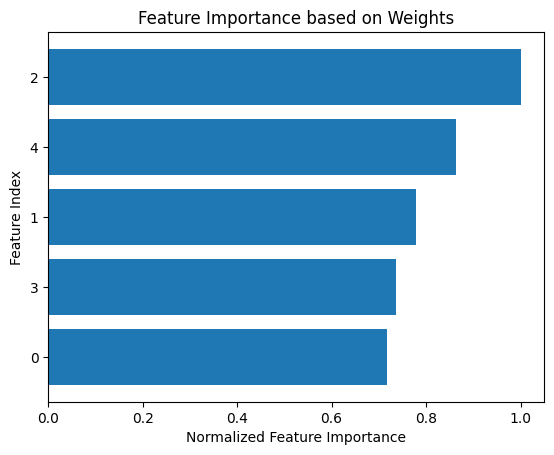

In [ ]:
weights = Hyp_Model_1.model.layers[0].get_weights()[0]

# Calculate feature importance based on weights
feature_importance = np.sum(np.abs(weights), axis=1)

# Normalize the feature importance values
feature_importance /= np.max(feature_importance)

# Sort the features by importance
sorted_indices = np.argsort(feature_importance)

# Plot the feature importance
plt.barh(range(5), feature_importance[sorted_indices])
plt.yticks(range(5), sorted_indices)
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature Index')
plt.title('Feature Importance based on Weights')
plt.show()



These lines calculate the feature importance based on the weights of the input layer neurons in the trained model. The absolute values of the weights are summed along each row (neuron), normalized, and then sorted to show the importance of each feature. A horizontal bar plot is used to visualize the feature importance. It represents the feature 2 has more impact and 3 has the less impact.

In [ ]:
import os
#Setting the minimum tensorflow loggin level to suppressing level to avoid displaying log messages except FATAL messages
os.environ["TF_CPP_MIN_LOG_LEVEL"]="5"
history = randSearch_1.fit(X_train, y_train,verbose=0)

In [ ]:
# Getting the best combination of hyperparameters found during the search
best_params = randSearch_1.best_params_

# Getting the model with those hyperparameters that performed the best during the grid search.
best_estimators = randSearch_1.best_estimator_

print("Best params : ",best_params)
print("Best Estimators : ",best_estimators)

Best params :  {'batch_size': 75, 'epochs': 5}
Best Estimators :  KerasRegressor(
	model=<keras.engine.sequential.Sequential object at 0x7e126925a320>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=75
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=5
)


In [ ]:
#This code uses the best estimator to make predictions on the test data (X_test) and assigns the predictions to y_prediction.
#Then, the calculateMetrics function is called to compute various metrics (mean absolute error, mean squared error, root mean squared error, and R-squared)
#by comparing the predicted values to the true values (y_test).
y_prediction = best_estimators.predict(X_test)
y_prediction


156/156 [==============================] - 1s 3ms/step


array([[48.727894],
       [48.746277],
       [44.880978],
       ...,
       [49.990486],
       [40.622253],
       [39.07187 ]], dtype=float32)

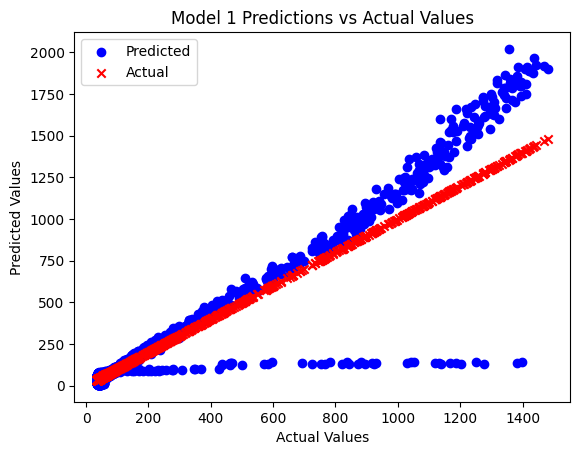

In [ ]:
plt.scatter(y_prediction, y_test, color='blue', label='Predicted', marker='o')
plt.scatter(y_prediction, y_prediction, color='red', label='Actual', marker='x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 1 Predictions vs Actual Values')
plt.legend()
plt.show()

In [ ]:
calculateMetrics(y_prediction, y_test)
adjusted_r_squared(y_prediction, y_test,n=(len(y_test)+len(y_train)),p=len(y_prediction))
#Calculating the Error values

Mean Absolute Error (MAE): 21.301145201617476
Mean Squared Error (MSE): 3759.1651448692173
Root Mean Squared Error (RMSE): 61.312030996120306
R-squared (Coefficient of Determination): 0.8508246760497982
Adjusted R-squared: 0.7868877103300619


0.7868877103300619

#Model 2

**Model 2:**
Applying L1 and L2 regularization. Regularization helps prevent overfitting by adding a penalty term to the loss function based on the magnitude of the weights. Adding dropout layer to prevent overfitting during training.

In [ ]:
Create_model_2 = Sequential()

#Input Layer
Create_model_2.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))

#Hidden Layer
#Applying L1 regularization on the kernel weights and L2 regularization on the bias weights.
Create_model_2.add(Dense(512,kernel_initializer='normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01), bias_regularizer=tf.keras.regularizers.l2(0.015)))

#Adding dropout layer to randomly drops a fraction of neurons during training to prevent overfitting.
Create_model_2.add(Dropout(0.3))

Create_model_2.add(Dense(256,kernel_initializer='normal', activation='relu'))
Create_model_2.add(Dropout(0.3))
Create_model_2.add(Dense(128,kernel_initializer='normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01), bias_regularizer=tf.keras.regularizers.l2(0.015)))
Create_model_2.add(Dropout(0.3))
Create_model_2.add(Dense(64,kernel_initializer='normal', activation='relu'))
Create_model_2.add(Dropout(0.3))
Create_model_2.add(Dense(32,kernel_initializer='normal', activation='relu'))
Create_model_2.add(Dropout(0.3))
#Output Layer
Create_model_2.add(Dense(1,kernel_initializer='normal', activation = 'relu'))

#Creating an instance of the Adam optimizer with a learning rate of 0.01.
opt = keras.optimizers.Adam(learning_rate=0.01)

Create_model_2.compile(loss = 'MeanSquaredError', optimizer=opt, metrics=['mse','mae'])

#Printing thr summary of the model architecture, showing the number of parameters and the structure of each layer.
Create_model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 5)                 30        
                                                                 
 dense_28 (Dense)            (None, 512)               3072      
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

These lines create a new sequential neural network model Create_model_2. An input layer is added to the model, similar to the previous model. The activation function used is ReLU ('relu'), and input_dim is set to the number of features in the training data. Hidden layer to the model with 512 neurons and ReLU activation function. It applies L1 regularization to the kernel weights (kernel_regularizer) with a regularization strength of 0.01, and L2 regularization to the bias weights (bias_regularizer) with a regularization strength of 0.015. A dropout layer is added after the first hidden layer. Dropout randomly drops a fraction of neurons during each training iteration, which helps prevent overfitting. More hidden layers to the model, each followed by a dropout layer. The structure is similar to the previous hidden layer. The dropout rate is set to 0.3, which means that during training, approximately 30% of the neurons in the dropout layers will be randomly set to zero.

Early stopping

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='mse', verbose=1, patience=5)

history = Create_model_2.fit(X_train, y_train, batch_size=25, epochs=100, callbacks=[es])

Epoch 1/100
1092/1092 [==============================] - 15s 8ms/step - loss: 16715.2090 - mse: 16698.1074 - mae: 45.1149
Epoch 2/100
1092/1092 [==============================] - 11s 10ms/step - loss: 15868.0967 - mse: 15846.5049 - mae: 39.8768
Epoch 3/100
1092/1092 [==============================] - 10s 9ms/step - loss: 17494.1641 - mse: 17466.6484 - mae: 40.4933
Epoch 4/100
1092/1092 [==============================] - 10s 9ms/step - loss: 14604.7979 - mse: 14569.4482 - mae: 36.7300
Epoch 5/100
1092/1092 [==============================] - 5s 5ms/step - loss: 11359.1631 - mse: 11318.7256 - mae: 33.5202
Epoch 6/100
1092/1092 [==============================] - 6s 6ms/step - loss: 11563.7969 - mse: 11520.9004 - mae: 32.6056
Epoch 7/100
1092/1092 [==============================] - 5s 5ms/step - loss: 9359.1748 - mse: 9314.5869 - mae: 30.8376
Epoch 8/100
1092/1092 [==============================] - 6s 6ms/step - loss: 10282.3926 - mse: 10236.6191 - mae: 32.1639
Epoch 9/100
1092/1092 [======

An EarlyStopping callback is created, which monitors the mean squared error ('mse') on the validation set. If the validation mse does not improve for 5 consecutive epochs, training will stop early. The model is trained using the fit method, where X_train and y_train are the training data and labels, respectively. A batch size of 25 and a maximum of 100 epochs are specified. The callbacks parameter includes the EarlyStopping callback.

**Feature Importance for model 2 based on weights**

[0.50124866 1.654139   0.49304178 1.0692514  0.9230063 ]


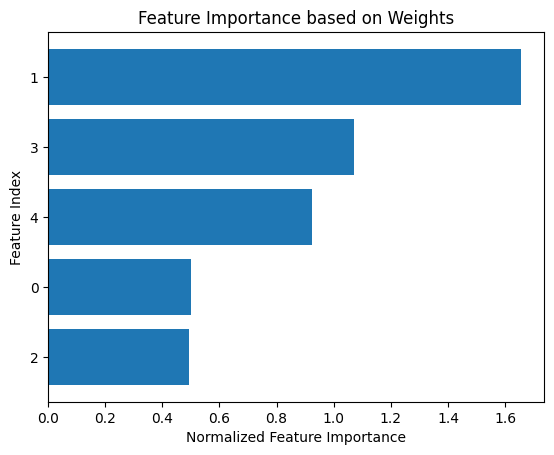

In [ ]:
weights = Create_model_2.layers[0].get_weights()[0]

# Calculate feature importance based on weights
#feature_importance = np.sum(np.abs(weights), axis=1)
feature_importance = np.abs(weights).sum(axis=1)
print(feature_importance)
# Normalize the feature importance values
#feature_importance /= np.max(feature_importance)


# Sort the features by importance
sorted_indices = np.argsort(feature_importance)

# Plot the feature importance
plt.barh(range(5), feature_importance[sorted_indices])
plt.yticks(range(5), sorted_indices)
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature Index')
plt.title('Feature Importance based on Weights')
plt.show()


These lines calculate the feature importance based on the weights of the input layer neurons in the trained model. The absolute values of the weights are summed along each row (neuron), normalized, and then sorted to show the importance of each feature. A horizontal bar plot is used to visualize the feature importance. It represents the feature 1 has more impact and 2 has the less impact.

In [ ]:
from matplotlib import pyplot

train_acc = Create_model_2.evaluate(X_train, y_train)
test_acc = Create_model_2.evaluate(X_test, y_test)
model_2_prediction = Create_model_2.predict(X_test)

calculateMetrics(model_2_prediction, y_test)
adjusted_r_squared(model_2_prediction, y_test,n=(len(y_test)+len(y_train)),p=len(model_2_prediction))
model_2_prediction

366/366 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 29.119678484694298
Mean Squared Error (MSE): 7401.742377486728
Root Mean Squared Error (RMSE): 86.03337943778989
R-squared (Coefficient of Determination): 0.5789954918059359
Adjusted R-squared: 0.39855176897384015


array([[49.578125],
       [49.578125],
       [49.578125],
       ...,
       [49.578125],
       [49.578125],
       [49.578125]], dtype=float32)

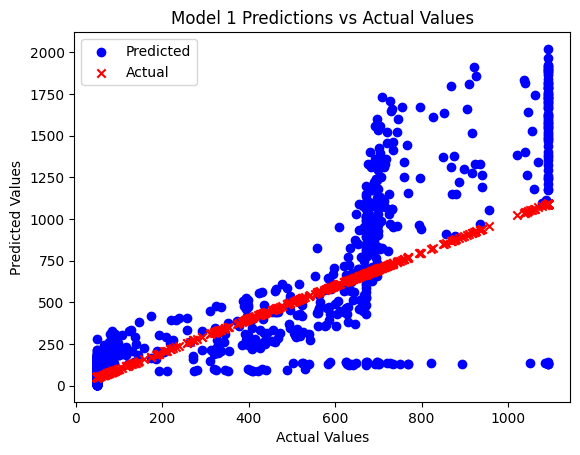

In [ ]:
# Plot actual vs. predicted values

plt.scatter(model_2_prediction, y_test, color='blue', label='Predicted', marker='o')
plt.scatter(model_2_prediction,model_2_prediction, color='red', label='Actual', marker='x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 1 Predictions vs Actual Values')
plt.legend()
plt.show()

#Model 3


**Model 3:**
Model3 has 3 hidden layers with the elu activation function, and we use the RMSprop optimizer with learning rate=0.0005.

In [ ]:
# Third model - 3 hidden layers with elu activation, rmsprop optimizer with learning rate=0.0005
model3 = tf.keras.models.Sequential()
model3.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))
model3.add(tf.keras.layers.Dense(256, activation='elu'))
model3.add(tf.keras.layers.Dense(64, activation='elu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt3 = tf.keras.optimizers.RMSprop(learning_rate=0.0005)

model3.compile(optimizer=opt3, loss='binary_crossentropy', metrics=['mse','mae'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 5)                 30        
                                                                 
 dense_35 (Dense)            (None, 256)               1536      
                                                                 
 dense_36 (Dense)            (None, 64)                16448     
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,079
Trainable params: 18,079
Non-trainable params: 0
_________________________________________________________________


These lines create the third model, referred to as model3. It's a sequential neural network model. Here's a breakdown of the layers added to the model:

An input layer is added, similar to the previous models. It has the same number of neurons as the features in the training data (X_train.shape[1]), and the activation function used is ReLU ('relu').

A hidden layer is added with 256 neurons and the Exponential Linear Unit (ELU) activation function ('elu'). ELU is another type of activation function that can help mitigate the vanishing gradient problem.

Another hidden layer is added with 64 neurons and the ELU activation function.

The output layer is added with a single neuron and the sigmoid activation function. The sigmoid activation is used in binary classification problems to produce a probability output.

The RMSprop optimizer is used with a learning rate of 0.0005. The loss function is set to 'binary_crossentropy', which is commonly used for binary classification problems. The metrics 'mse' (mean squared error) and 'mae' (mean absolute error) are specified for monitoring during training. The summary() function is used to print a summary of the model's architecture.

In [ ]:
es2 = EarlyStopping(monitor='mse', verbose=1, patience=5)

history_3 = model3.fit(X_train, y_train, batch_size=25, epochs=50, callbacks=[es2])

Epoch 1/50
1092/1092 [==============================] - 5s 5ms/step - loss: -22069301477376.0000 - mse: 37920.3438 - mae: 79.2691
Epoch 2/50
1092/1092 [==============================] - 4s 4ms/step - loss: -22876692414464.0000 - mse: 37920.3555 - mae: 79.2691
Epoch 3/50
1092/1092 [==============================] - 5s 4ms/step - loss: -23714865348608.0000 - mse: 37920.3633 - mae: 79.2691
Epoch 4/50
1092/1092 [==============================] - 5s 5ms/step - loss: -24585699328000.0000 - mse: 37920.3555 - mae: 79.2691
Epoch 5/50
1092/1092 [==============================] - 4s 4ms/step - loss: -25444757798912.0000 - mse: 37920.3867 - mae: 79.2691
Epoch 6/50
1092/1092 [==============================] - 4s 4ms/step - loss: -26339203612672.0000 - mse: 37920.3633 - mae: 79.2691
Epoch 6: early stopping


In [ ]:
#Model 3 Prediction
model_3_prediction = model3.predict(X_test)
model_3_prediction[0:20]

366/366 [==============================] - 1s 3ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

#Model 4

Reduced the Hidden Layers.

In [ ]:
Create_model_4 = Sequential()

#Input Layer
Create_model_4.add(Dense(X_train.shape[1], activation='relu', input_dim = X_train.shape[1]))

#Hidden Layer
#Applying L1 regularization on the kernel weights and L2 regularization on the bias weights.
Create_model_4.add(Dense(512,kernel_initializer='normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01), bias_regularizer=tf.keras.regularizers.l2(0.015)))

#Adding dropout layer to randomly drops a fraction of neurons during training to prevent overfitting.
Create_model_4.add(Dropout(0.3))

Create_model_4.add(Dense(256,kernel_initializer='normal', activation='relu'))
Create_model_4.add(Dropout(0.3))
Create_model_4.add(Dense(128,kernel_initializer='normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01), bias_regularizer=tf.keras.regularizers.l2(0.015)))
Create_model_4.add(Dropout(0.3))



#Output Layer
Create_model_4.add(Dense(1,kernel_initializer='normal', activation = 'relu'))

#Creating an instance of the Adam optimizer with a learning rate of 0.01.
opt = keras.optimizers.Adam(learning_rate=0.01)

Create_model_4.compile(loss = 'MeanSquaredError', optimizer=opt, metrics=['mse','mae'])

#Printing thr summary of the model architecture, showing the number of parameters and the structure of each layer.
Create_model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 5)                 30        
                                                                 
 dense_39 (Dense)            (None, 512)               3072      
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)              

In [ ]:
#Early stopping
#------------------------
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='mse', verbose=1, patience=5)

history = Create_model_4.fit(X_train, y_train, batch_size=25, epochs=100, callbacks=[es])

Epoch 1/100
1092/1092 [==============================] - 7s 4ms/step - loss: 8352.6396 - mse: 8334.1973 - mae: 31.0523
Epoch 2/100
1092/1092 [==============================] - 5s 5ms/step - loss: 6419.4429 - mse: 6399.3086 - mae: 27.5630
Epoch 3/100
1092/1092 [==============================] - 5s 5ms/step - loss: 6966.0527 - mse: 6945.5908 - mae: 28.0816
Epoch 4/100
1092/1092 [==============================] - 6s 6ms/step - loss: 6289.4399 - mse: 6267.5234 - mae: 23.9787
Epoch 5/100
1092/1092 [==============================] - 5s 4ms/step - loss: 6371.2979 - mse: 6345.9209 - mae: 22.1061
Epoch 6/100
1092/1092 [==============================] - 5s 5ms/step - loss: 6432.8369 - mse: 6401.4961 - mae: 21.5972
Epoch 7/100
1092/1092 [==============================] - 5s 5ms/step - loss: 6606.9443 - mse: 6572.3555 - mae: 22.0029
Epoch 8/100
1092/1092 [==============================] - 6s 5ms/step - loss: 5708.8579 - mse: 5669.8125 - mae: 20.4365
Epoch 9/100
1092/1092 [=========================

[1.3276672 6.9143114 1.4139119 0.5980009 0.7259913]


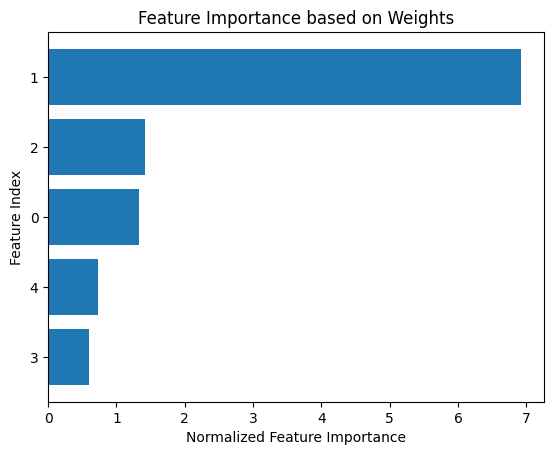

In [ ]:
weights = Create_model_4.layers[0].get_weights()[0]

# Calculate feature importance based on weights
#feature_importance = np.sum(np.abs(weights), axis=1)
feature_importance = np.abs(weights).sum(axis=1)
print(feature_importance)
# Normalize the feature importance values
#feature_importance /= np.max(feature_importance)


# Sort the features by importance
sorted_indices = np.argsort(feature_importance)

# Plot the feature importance
plt.barh(range(5), feature_importance[sorted_indices])
plt.yticks(range(5), sorted_indices)
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature Index')
plt.title('Feature Importance based on Weights')
plt.show()

In [ ]:
#result

from matplotlib import pyplot

train_acc = Create_model_4.evaluate(X_train, y_train)
test_acc = Create_model_4.evaluate(X_test, y_test)
model_4_prediction = Create_model_4.predict(X_test)

calculateMetrics(model_4_prediction, y_test)
adjusted_r_squared(model_4_prediction, y_test,n=(len(y_test)+len(y_train)),p=len(model_4_prediction))

366/366 [==============================] - 1s 3ms/step - loss: 5055.5615 - mse: 4990.0874 - mae: 18.9712


366/366 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 18.971184768925813
Mean Squared Error (MSE): 4990.086899140178
Root Mean Squared Error (RMSE): 70.64054713222554
R-squared (Coefficient of Determination): 0.8754029693398925
Adjusted R-squared: 0.8220003296328349


0.8220003296328349

In [ ]:
model_4_prediction

array([[72.19784 ],
       [49.945717],
       [76.341606],
       ...,
       [50.484634],
       [71.660286],
       [42.554737]], dtype=float32)

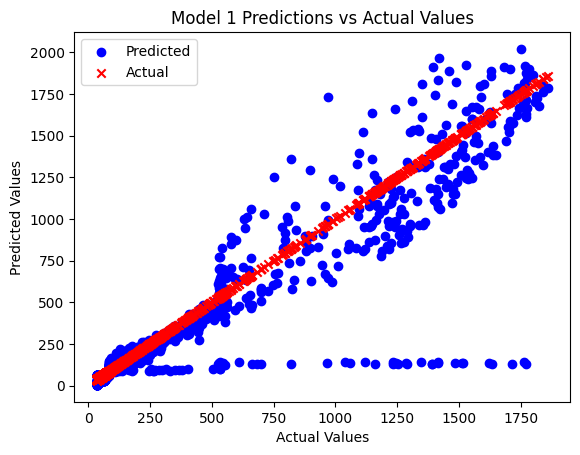

In [ ]:
# Plot actual vs. predicted values
plt.scatter(model_4_prediction, y_test, color='blue', label='Predicted', marker='o')
plt.scatter(model_4_prediction, model_4_prediction, color='red', label='Actual', marker='x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 4 Predictions vs Actual Values')
plt.legend()
plt.show()

In [ ]:
from tabulate import tabulate

# Define the data for the table
data = [
    ["Model 1", 21.301145201617476, 3759.1651448692173, 61.312030996120306, 0.8508246760497982, 0.7868877103300619],
    ["Model 2", 29.119678484694298, 7401.742377486728, 86.03337943778989, 0.5789954918059359, 0.39855176897384015],
    ["Model 3", '-', '-', '-', '-', '-'],
    ["Model 4", 18.971184768925813, 4990.086899140178, 70.64054713222554, 0.8754029693398925, 0.8220003296328349]
]

# Define the headers for the table
headers = ["Model", "Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "R-squared", "Adjusted R-squared"]

# Print the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+---------+-----------------------------+----------------------------+----------------------------------+--------------------+----------------------+
| Model   | Mean Absolute Error (MAE)   | Mean Squared Error (MSE)   | Root Mean Squared Error (RMSE)   | R-squared          | Adjusted R-squared   |
+=========+=============================+============================+==================================+====================+======================+
| Model 1 | 21.301145201617476          | 3759.1651448692173         | 61.312030996120306               | 0.8508246760497982 | 0.7868877103300619   |
+---------+-----------------------------+----------------------------+----------------------------------+--------------------+----------------------+
| Model 2 | 29.119678484694298          | 7401.742377486728          | 86.03337943778989                | 0.5789954918059359 | 0.39855176897384015  |
+---------+-----------------------------+----------------------------+------------------------------

#Test Set


**Until now the code is done for the Train set. But the test set has to be prepared for it.**

**The following are for the Test set**

In [ ]:
dataframe_test = pd.read_csv("/content/sample_data/test.csv")
#dataframe_test = pd.read_csv(file_url_test)
dataframe_test

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B
...,...,...,...,...,...,...,...,...,...,...,...
797,t353400176448,2017-10-26,day,NaN,S4,D1,1000,NaN,489,TT,C
798,t112945848426,2018-09-01,day,NaN,S8,D3,2200,NaN,12,NaN,B
799,t53097944970,2018-06-20,day,NaN,S9,D2,2200,NaN,9,NaN,B
800,t127986960246,2019-01-13,night,NaN,S3,D3,1200,expedited,11,NaN,D


In [ ]:
formatDate(dataframe_test)

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,day_of_week,month,year
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C,2,9,2017
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A,1,12,2017
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D,6,11,2018
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B,0,11,2019
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B,6,6,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,t353400176448,2017-10-26,day,NaN,S4,D1,1000,NaN,489,TT,C,3,10,2017
798,t112945848426,2018-09-01,day,NaN,S8,D3,2200,NaN,12,NaN,B,5,9,2018
799,t53097944970,2018-06-20,day,NaN,S9,D2,2200,NaN,9,NaN,B,2,6,2018
800,t127986960246,2019-01-13,night,NaN,S3,D3,1200,expedited,11,NaN,D,6,1,2019


# **Data Preprocessing for Test set**

In [ ]:
#Dropping the columns
dfMT = dataframe_test.drop(['trip','date'],axis=1)
dfMT = findModeAndApplyModeToNullValues(dfMT)

#Doing one-hot encoding to fill/replace the values with feasible values to train the model
dfMT =pd.get_dummies(dfMT, columns=['dayPart','carrier','exWeatherTag','originLocation','destinationLocation','type','packageType'])

#MinMaxScaler expects a 2D array as input for the fit_transform() method. However, the 'distance' column you provided is in 1D form
# Reshape the 'distance' column to a 2D array
distance_2d = dfMT['distance'].values.reshape(-1, 1)

dfMT

,distance,weight,day_of_week,month,year,dayPart_day,dayPart_night,carrier_A,carrier_B,carrier_C,...,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9,type_expedited,packageType_TT
0,2000,50,2,9,2017,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,1
1,600,22,1,12,2017,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1600,30,6,11,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2200,32,0,11,2019,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
4,2600,7,6,6,2019,0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,1000,489,3,10,2017,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
798,2200,12,5,9,2018,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
799,2200,9,2,6,2018,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1
800,1200,11,6,1,2019,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1


In [ ]:
#Getting no of columns in the Train data frame Modified

columns_list = train_set.columns.tolist()

print(columns_list)

['distance', 'weight', 'cost', 'day_of_week', 'month', 'year', 'dayPart_day', 'dayPart_night', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D', 'exWeatherTag_heat', 'exWeatherTag_normal', 'exWeatherTag_snow', 'originLocation_S1', 'originLocation_S2', 'originLocation_S3', 'originLocation_S4', 'originLocation_S5', 'originLocation_S6', 'originLocation_S7', 'originLocation_S8', 'originLocation_S9', 'destinationLocation_D1', 'destinationLocation_D2', 'destinationLocation_D3', 'destinationLocation_D4', 'destinationLocation_D5', 'destinationLocation_D6', 'destinationLocation_D7', 'destinationLocation_D8', 'destinationLocation_D9', 'type_expedited', 'packageType_TT']


In [ ]:
#Getting no of columns in the Test data frame Modified

columns_list = dfMT.columns.tolist()

print(columns_list)

['distance', 'weight', 'day_of_week', 'month', 'year', 'dayPart_day', 'dayPart_night', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D', 'exWeatherTag_heat', 'exWeatherTag_normal', 'exWeatherTag_snow', 'originLocation_S1', 'originLocation_S2', 'originLocation_S3', 'originLocation_S4', 'originLocation_S5', 'originLocation_S6', 'originLocation_S7', 'originLocation_S8', 'originLocation_S9', 'destinationLocation_D1', 'destinationLocation_D2', 'destinationLocation_D3', 'destinationLocation_D4', 'destinationLocation_D5', 'destinationLocation_D6', 'destinationLocation_D7', 'destinationLocation_D8', 'destinationLocation_D9', 'type_expedited', 'packageType_TT']


In [ ]:
common_columns = train_set.columns.intersection(dfMT.columns)
print(common_columns)

Index(['distance', 'weight', 'day_of_week', 'month', 'year', 'dayPart_day',
       'dayPart_night', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D',
       'exWeatherTag_heat', 'exWeatherTag_normal', 'exWeatherTag_snow',
       'originLocation_S1', 'originLocation_S2', 'originLocation_S3',
       'originLocation_S4', 'originLocation_S5', 'originLocation_S6',
       'originLocation_S7', 'originLocation_S8', 'originLocation_S9',
       'destinationLocation_D1', 'destinationLocation_D2',
       'destinationLocation_D3', 'destinationLocation_D4',
       'destinationLocation_D5', 'destinationLocation_D6',
       'destinationLocation_D7', 'destinationLocation_D8',
       'destinationLocation_D9', 'type_expedited', 'packageType_TT'],
      dtype='object')


In [ ]:
dfMT

,distance,weight,day_of_week,month,year,dayPart_day,dayPart_night,carrier_A,carrier_B,carrier_C,...,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9,type_expedited,packageType_TT
0,2000,50,2,9,2017,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,1
1,600,22,1,12,2017,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1600,30,6,11,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2200,32,0,11,2019,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
4,2600,7,6,6,2019,0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,1000,489,3,10,2017,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
798,2200,12,5,9,2018,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
799,2200,9,2,6,2018,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1
800,1200,11,6,1,2019,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1


In [ ]:
# Splitting the Data into Training and Testing Sets
columns_categorical_list = list(columns_categorical)
columns_numerical_list = list(columns_numerical)
pipeline_numerical = Pipeline([
  ('scaler', StandardScaler()),
])

pipeline_full_test = ColumnTransformer([
  ("numerical", pipeline_numerical, columns_numerical_list),
])

In [ ]:
# Fit the feature scaling pipeline on the test data
pipeline_full_test.fit(dfMT)

# Transform the test data using the fitted pipeline
transform_dfMT = pipeline_full.transform(dfMT)

# Print the shape of the transformed test data
print(f"dfMT transformed.shape: {transform_dfMT.shape}")

dfMT transformed.shape: (802, 5)


In [ ]:
# Predictions using different models on the transformed test data
model_1_prediction = best_estimators.predict(transform_dfMT)
model_1_prediction[0:20]


11/11 [==============================] - 0s 2ms/step


array([[ 48.47291 ],
       [ 47.016937],
       [ 43.202507],
       [ 44.912365],
       [ 53.538425],
       [ 39.438313],
       [ 39.438313],
       [ 38.180023],
       [ 45.497692],
       [ 58.756218],
       [ 56.42686 ],
       [ 45.359947],
       [ 46.41702 ],
       [ 53.057034],
       [ 38.723145],
       [ 43.024826],
       [707.4411  ],
       [ 45.70283 ],
       [ 43.078102],
       [ 41.0594  ]], dtype=float32)

In [ ]:
model_2_prediction = Create_model_2.predict(transform_dfMT)
model_2_prediction[0:20]

26/26 [==============================] - 0s 2ms/step


array([[ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125],
       [568.23456 ],
       [ 49.578125],
       [ 49.578125],
       [ 49.578125]], dtype=float32)